# Proyecto Inteligencia Artificial
Stefano Aragoni, Luis Diego Santos, Carol Arevalo

______________________

El objetivo del presente proyecto es detectar los tweets que puedan estar relacionados con cyberbulling. Para ello se descargo una base de datos de tweets del 2020. 

### Exploración y Limpieza de Datos
Como primer paso, se importa el archivo a través de distintas librerías. 

In [1]:
#importar librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from tqdm import tqdm
from collections import Counter
import re

from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from prettytable import PrettyTable
from sklearn.feature_extraction.text import CountVectorizer
import pandas_profiling
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_62046/2456687728.py:31: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stefanoaragoni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/stefanoaragoni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#cargar dataset
data = pd.read_csv('cyberbullying_tweets.csv')

In [3]:
# Imprimir las primeras 5 filas
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [4]:
# Imprimir las últimas 5 filas
data.tail()

,tweet_text,cyberbullying_type
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...,ethnicity


In [5]:
#imprimir la cantidad de filas y columnas
data.shape

(47692, 2)

##### Datos Faltantes
En este caso, primero se analizó si hacían falta datos en el dataset. En este caso, todos los datos estaban almacenados y no habían datos fuera de lugar.

Index([], dtype='object')

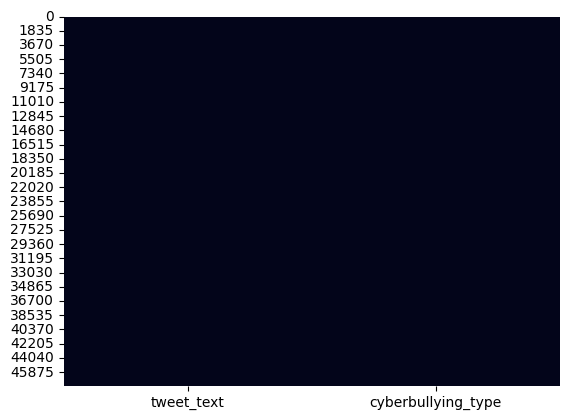

In [6]:
# Matriz de datos faltantes
sns.heatmap(data.isnull(), cbar=False)

# Mostrar columnas con datos faltantes, o con datos fuera de lugar (como un string en columna numérica)
data.columns[data.isnull().any()]

##### Datos Duplicados
Se buscaron datos dupllicados para eliminarlos y tener un modelo más exacto.


In [7]:
data['tweet_text'] = data['tweet_text'].str.lower()

#verificar datos duplicados
data.duplicated().sum()

59

In [8]:
#eliminar datos duplicados
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

##### Distribución de clases
Este tipo de análisis es útil para obtener una mejor comprensión de la distribución de los diferentes tipos de ciberacoso en los datos y para identificar los tipos de ciberacoso más comunes en un conjunto de datos.

In [9]:
#distriubución de los datos
data.describe()

,tweet_text,cyberbullying_type
count,47633,47633
unique,45991,6
top,@iglvzx he expects unix logins to map to githu...,religion
freq,2,7994


In [10]:
# Contar la frecuencia de cada valor único en la columna "cyberbullying_type"
frecuencias = data['cyberbullying_type'].value_counts()

# Mostrar los resultados
print(frecuencias)

religion               7994
age                    7979
ethnicity              7953
gender                 7947
not_cyberbullying      7937
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64


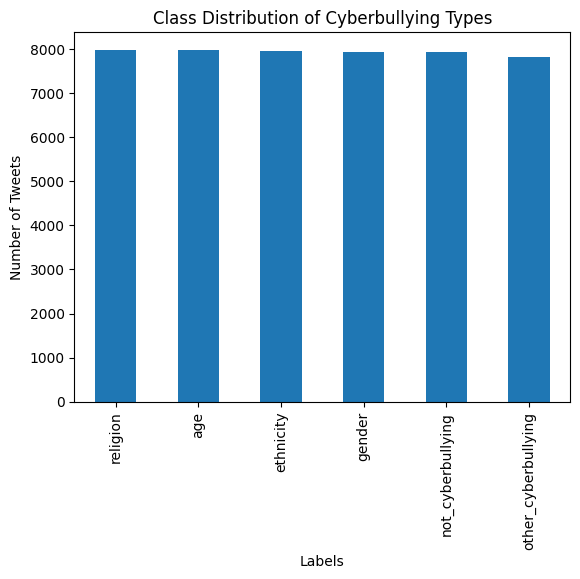

In [11]:
# Create a bar plot of the class distribution
class_counts = data['cyberbullying_type'].value_counts()
class_counts.plot(kind='bar')
plt.title('Class Distribution of Cyberbullying Types')
plt.xlabel('Labels')
plt.ylabel('Number of Tweets')
plt.show()

En este caso, las clases no están balanceadas. Por lo cual se realizará undersampling para balancear las clases.

In [12]:
from imblearn.under_sampling import RandomUnderSampler 
rus = RandomUnderSampler(random_state=42)

data2 = data['tweet_text'].to_numpy().reshape(-1, 1) # reshape data2 to have one column

# Aplicar el método de submuestreo
X_res, y_res = rus.fit_resample(data2, data['cyberbullying_type'])

# Crear un nuevo dataframe con los datos submuestreados, con los nombres de las columnas originales
data = pd.DataFrame({
    'tweet_text': X_res.flatten(),
    'cyberbullying_type': y_res
})

# Contar la frecuencia de cada valor único en la columna "cyberbullying_type"
frecuencias = data['cyberbullying_type'].value_counts()

# Mostrar los resultados
print(frecuencias)

age                    7823
ethnicity              7823
gender                 7823
not_cyberbullying      7823
other_cyberbullying    7823
religion               7823
Name: cyberbullying_type, dtype: int64


### Conteo de palabras 
A continuacion se hace un analisis de las palabras mas comunes de la base de datos. 

In [13]:
# Remover URLs, menciones y hashtags
def remove_urls_mentions_hashtags(text):
    text = re.sub(r'http\S+', '', text) # URLs
    text = re.sub(r'@\S+', '', text) # Menciones
    text = re.sub(r'#\S+', '', text) # Hashtags

    # stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    text = re.sub(r'[^a-zA-Z\s]', '', text) # Puntuación

    return text

for i in tqdm(range(len(data))):
    data['tweet_text'][i] = remove_urls_mentions_hashtags(data['tweet_text'][i])

100%|██████████| 46938/46938 [00:33<00:00, 1422.22it/s]


In [14]:
# Frecuencia de cada palabra
tweets = ' '.join(data['tweet_text'].values)
words = tweets.split()

top_10 = Counter(words).most_common(10)

top_10

[('school', 8529),
 ('like', 5776),
 ('fuck', 5711),
 ('dumb', 5238),
 ('high', 4989),
 ('people', 4739),
 ('bullied', 4578),
 ('im', 4432),
 ('rt', 4235),
 ('nigger', 4232)]

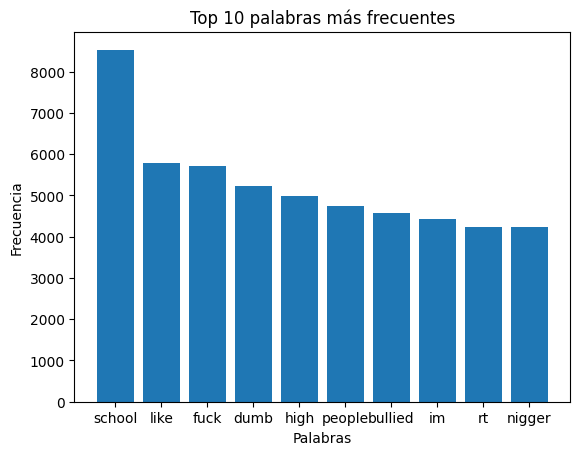

In [15]:
# diagrama de barras
plt.bar(*zip(*top_10))
plt.title('Top 10 palabras más frecuentes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.show()

## Creacion del Modelo




Como primer paso, se divide el dataset en 80% para entrenamiento, 10% para validación (tuning) y 10% para test

In [16]:
X = data['tweet_text'].to_numpy().reshape(-1, 1)
y = data['cyberbullying_type']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X.flatten()).toarray()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### Regresion Logistica

In [20]:
clf = LogisticRegression(C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

: 

: 

In [ ]:
# print the results for each model
table = PrettyTable()
table.field_names = ["NOMBRE", "ESTIMATED ACCURACY", "STD", "PARAMS"]
for res in info:
    table.add_row([res[0], res[1], res[2], res[3]])
print(table)